# **Forecasting challenge**

Alejandro Mendoza Medina
Jaime Álvarez Urueña

https://www.kaggle.com/competitions/probabilistic-forecasting-i-temperature

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

## **Dataset Analysis** 

In [4]:
train_and_public_df = pd.read_csv('data/temperature-forecasting-challenge/train_and_Public.csv')
train_and_public_df['date'] = pd.to_datetime(train_and_public_df['date'])
for col in train_and_public_df.select_dtypes(include=['float64']).columns:
    train_and_public_df[col] = train_and_public_df[col].astype('float16')

train_df = train_and_public_df[:64320]
test_df = train_and_public_df[64320:]

train_and_public_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67008 entries, 0 to 67007
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           67008 non-null  int64         
 1   date         67008 non-null  datetime64[ns]
 2   feature_AA   67008 non-null  float16       
 3   feature_AB   67008 non-null  float16       
 4   feature_BA   67008 non-null  float16       
 5   feature_BB   67008 non-null  float16       
 6   feature_CA   67008 non-null  float16       
 7   feature_CB   67008 non-null  float16       
 8   Temperature  67008 non-null  float16       
dtypes: datetime64[ns](1), float16(7), int64(1)
memory usage: 1.9 MB


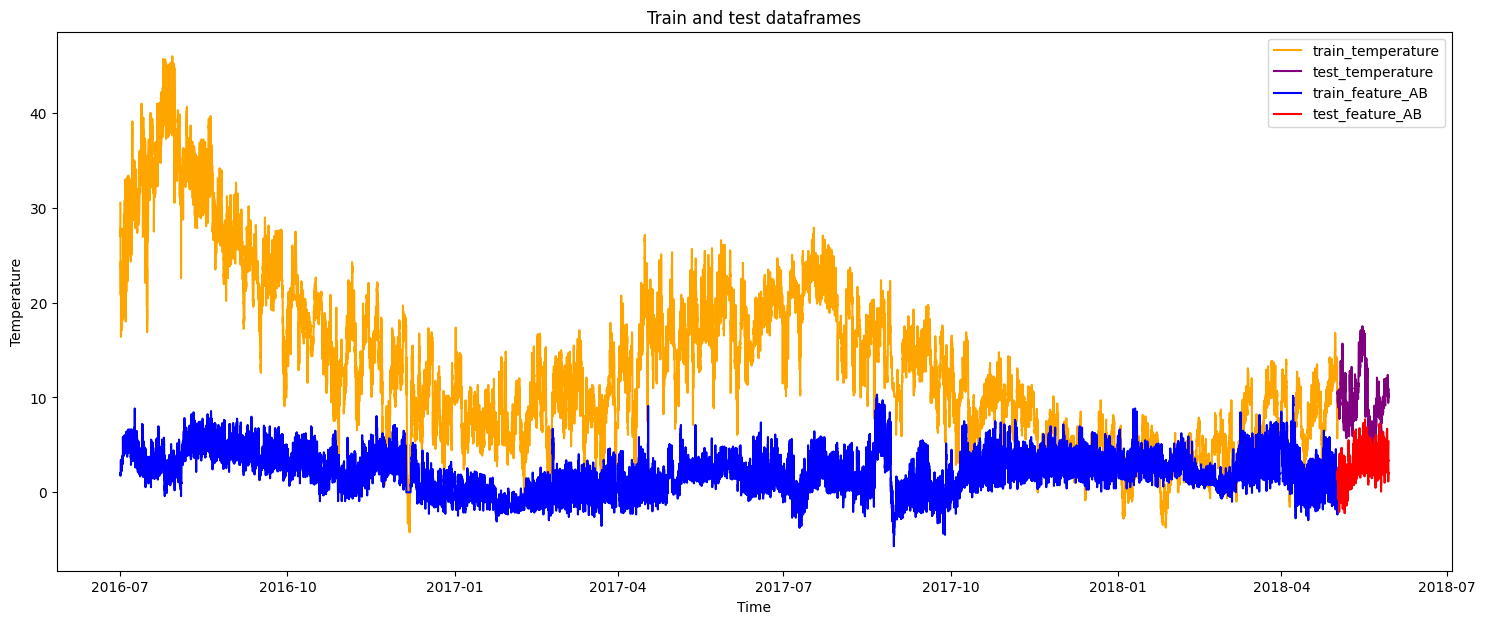

In [8]:
plt.figure(figsize=(18,7))
plt.plot(train_df['date'], train_df['Temperature'], label='train_temperature', color='orange')
plt.plot(test_df['date'], test_df['Temperature'], label='test_temperature', color='purple')
plt.plot(train_df['date'], train_df['feature_AB'], label='train_feature_AB', color='blue')
plt.plot(test_df['date'], test_df['feature_AB'], label='test_feature_AB', color='red')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Train and test dataframes")
plt.legend()
plt.show()

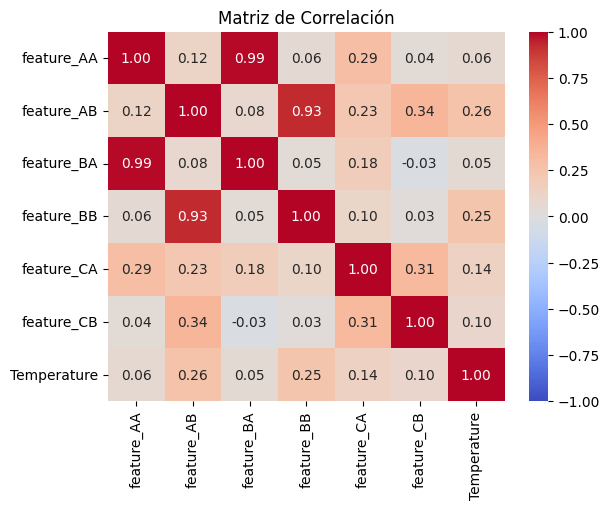

In [13]:
numerical_columns = train_df.select_dtypes(include=['float16']).columns
corr_matrix = train_df[numerical_columns].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

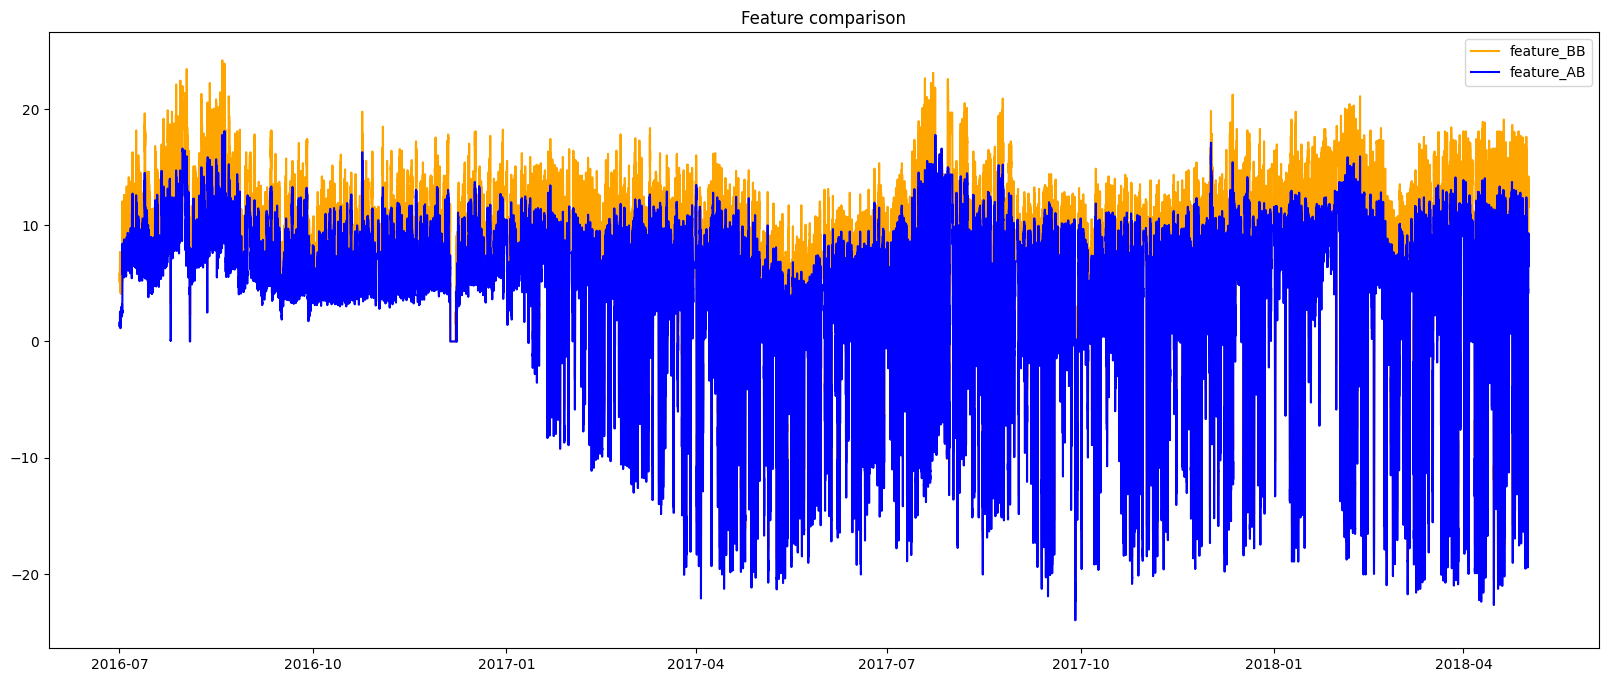

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(train_df['date'], train_df['feature_AA'].to_numpy(),label='feature_BB',color='orange')
plt.plot(train_df['date'], train_df['feature_BA'].to_numpy(),label='feature_AB',color='blue')
plt.title('Feature comparison')
plt.legend()
plt.show()

## **Models**

In [ ]:
def plot_and_validate(train_df: pd.DataFrame, test_df: pd.DataFrame, predictions: np.ndarray, model_name: str) -> None:
    if len(test_df.columns) > 1:
        for i, column in enumerate(test_df.columns):
            rmse = np.sqrt(mean_squared_error(test_df[column], predictions[:, i]))
            print(f"**** Test RMSE for {column}: {rmse:.3f} ****")
    else:
        rmse = np.sqrt(mean_squared_error(test_df.values, predictions))
        print(f"**** Test RMSE [{model_name}]: {rmse:.3f} ****")
        
    test_x = np.arange(len(train_df), len(train_df) + len(test_df))
    plt.figure(figsize=(18,6))
    plt.plot(train_df, label='Train Set')
    plt.plot(test_x, test_df, label='Test Set')
    plt.plot(test_x, predictions, label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{model_name}; Predictions vs Ground Truth')
    plt.legend()
    plt.show()

### Prophet

In [ ]:
model_prophet = Prophet(interval_width=0.95)
new_df = train_df.copy().reset_index().rename(columns={'index':'ds', 'value':'y'})

model_prophet.fit(new_df)
# Make Future Dataframe
future = model_prophet.make_future_dataframe(periods=len(test_df), freq='ME', include_history=False)
forecast = model_prophet.predict(future)

# Extract Predicted Values
predictions_prophet = forecast['yhat'].values[-len(test_df):]

# Calculate RMSE for Prophet
rmse_prophet = np.sqrt(mean_squared_error(test_df, predictions_prophet))
plot_and_validate(train_df, test_df, predictions_prophet, "Prophet Model")

# Use the plot with confidence intervals
model_prophet.plot(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

plot_components_plotly(m, forecast)

### Pytorch Forecasting: MQF2DistributionLoss

In [60]:
from pytorch_forecasting.metrics.distributions import MQF2DistributionLoss

In [ ]:
a = MQF2DistributionLoss()

### Random Forest

### LSTM